## Estadística e Inferencia II - 2do cuatrimestre 2025
### Escuela de Ciencia y Tecnología - Universidad Nacional de San Martín
#### Javier Spina - javierspina@gmail.com | jaspina@estudiantes.unsam.edu.ar

---

## Trabajo Práctico Integrador - Parte 1
# Análisis Bayesiano del Dataset Iris

Este notebook cubre las consignas especificadas en `consignas/TP_integrador_EeI_II__parte_1.pdf`

---

### Parte 1 - Análisis exploratorio del dataset IRIS

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris

sns.set_theme(style='white', palette='Set1')

In [2]:
iris = load_iris(as_frame=True).frame
iris['species'] = iris['target'].map({
    0: 'setosa',
    1: 'versicolor',
    2: 'virginica'
}).astype('category')
features = [c for c in iris.columns if c not in['target', 'species']]
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float64 
 1   sepal width (cm)   150 non-null    float64 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   target             150 non-null    int64   
 5   species            150 non-null    category
dtypes: category(1), float64(4), int64(1)
memory usage: 6.3 KB


In [3]:
iris.loc[:, iris.columns != "target"].describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


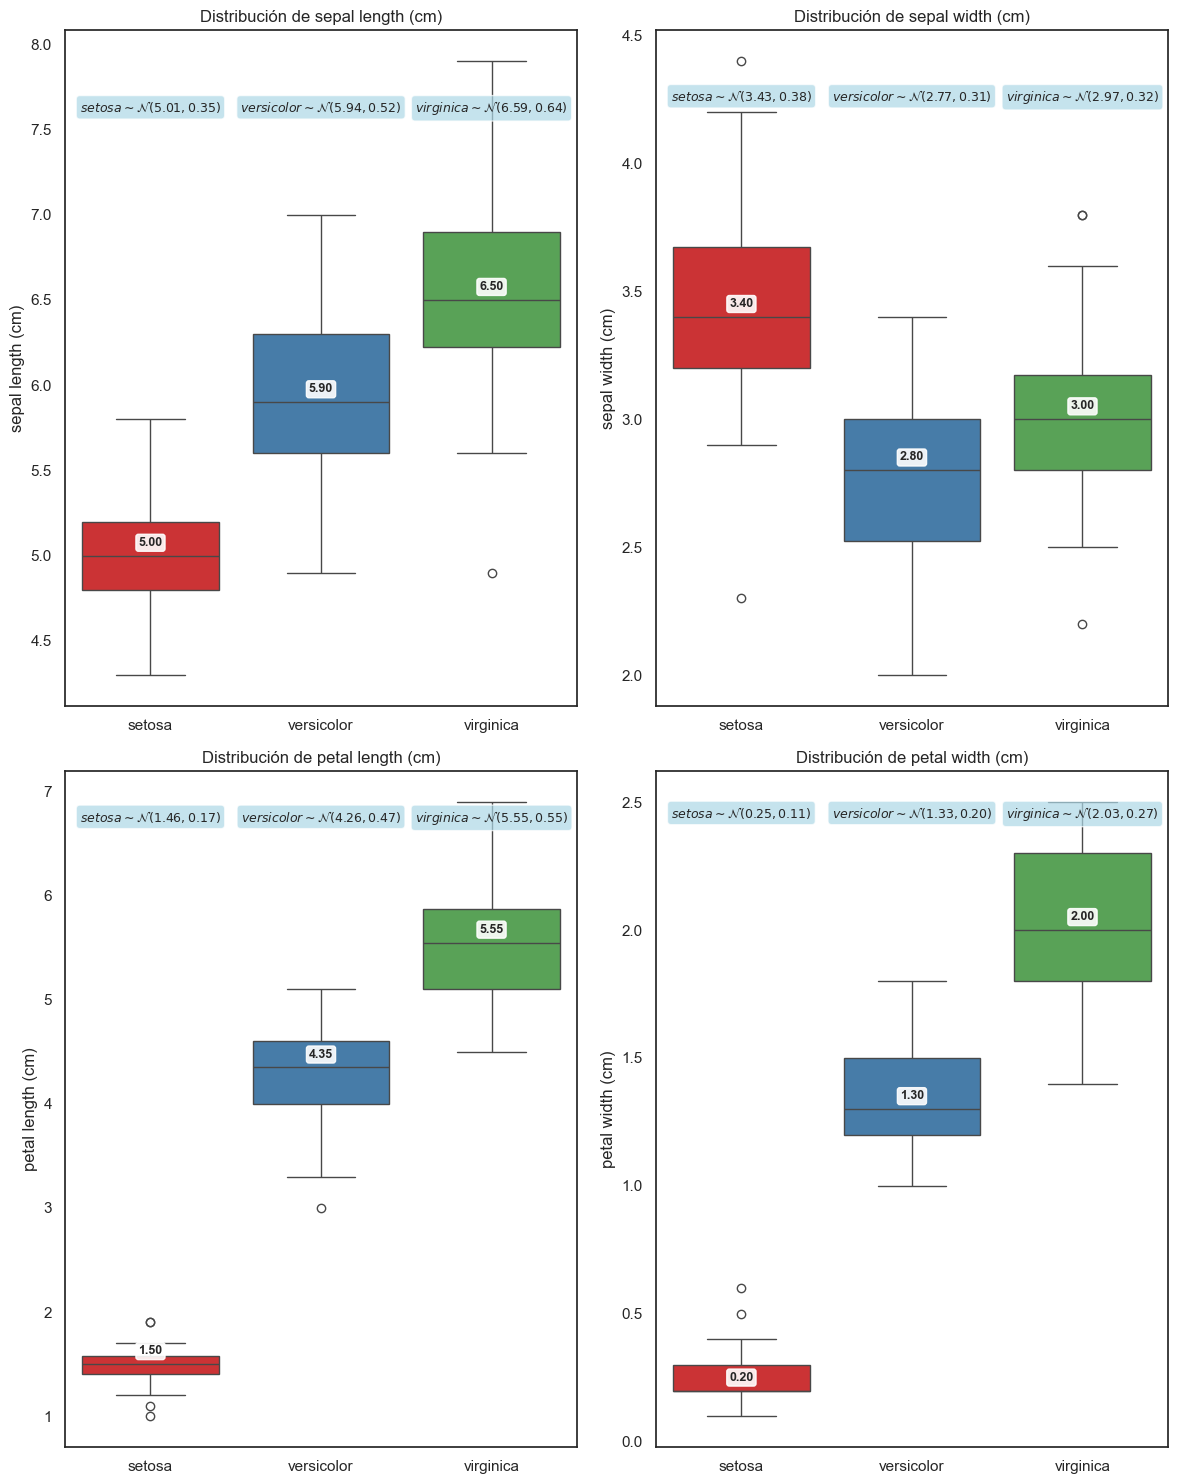

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 15))

for i, f in enumerate(features):
    ax = sns.boxplot(data=iris, y=f, x="species", hue="species", ax=axs[i // 2, i % 2])
    ax.set_xlabel("")

    for j, especie in enumerate(iris.species.unique()):
        data_especie = iris[iris["species"] == especie][f]
        media = data_especie.mean()
        desvio = data_especie.std()
        mediana = data_especie.median()

        # Usar annotate con offset para mejor posicionamiento
        ax.annotate(
            f"{mediana:.2f}",
            xy=(j, mediana),
            xytext=(0, 5),  # 5 puntos arriba de la mediana
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.9),
        )

        # Agregar leyenda en formato LaTeX
        leyenda = f"${especie} \\sim \\mathcal{{N}}({media:.2f}, {desvio:.2f})$"

        # Posicionar la leyenda arriba de cada boxplot
        ax.text(
            j,
            ax.get_ylim()[1] * 0.95,
            leyenda,  # 95% del límite superior
            ha="center",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
        )

    ax.set_title(f"Distribución de {f}")

plt.tight_layout()
plt.show()

> _Fig 1: Boxplot según especies y medidas_

In [5]:
iris.species.value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

El dataset `iris` tiene 150 observaciones, 4 features y un target. Las 4 features son numéricas, son las medidas del sépalo y del pétalo, en ancho y longitud de ambas. El target es el nombre de la variedad, osea es categórica. En la siguiente tabla un breve resumen

<style>
td, th {
   border: none!important;
}
</style>

Nombre | Es target? | Tipo | Rango 
-- | -- | -- | -- 
`sepal length (cm)` | no | `float` | $\in [4.3, 7.9]$
`sepal width (cm)` | no | `float` | $\in [2.0, 4.4]$
`petal length (cm)` | no | `float` | $\in [1.0, 6.9]$
`petal width (cm)` | no | `float` | $\in [0.1, 2.5]$
`species` | si | `object` | $\in [\text{setosa}, \text{versicolor}, \text{virginica}]$

**Variables numéricas**

Feature | Rango | Media | Mediana | Desvío
-- | -- | -- | -- | --
`sepal length (cm)` | $\in [4.3, 7.9]$ | $5.84$ | $5.80$ | $0.83$
`sepal width (cm)` | $\in [2.0, 4.4]$ | $3.06$ | $3.00$ | $0.44$
`petal length (cm)` | $\in [1.0, 6.9]$ | $3.76$ | $4.35$ | $1.76$
`petal width (cm)` | $\in [0.1, 2.5]$ | $1.20$ | $1.30$ | $0.76$

**Variable categórica (target)**
Variable | Valor | Frecuencia
-- | -- | -- 
`species` | $\text{setosa}$ | $50$ 
`species` | $\text{versicolor}$ | $50$ 
`species` | $\text{virginica}$ | $50$ 

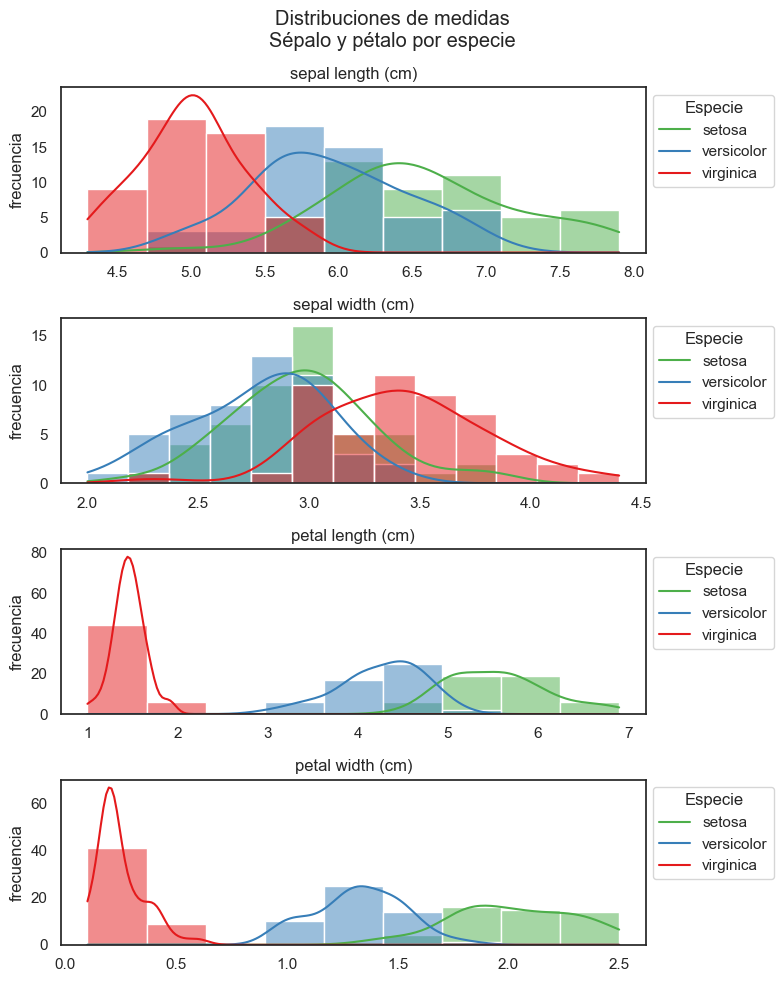

In [6]:
## Visualización univariada

xlims = [iris.min(numeric_only=True).min(), iris.max(numeric_only=True).max()]

fig, axs = plt.subplots(len(features), 1, figsize=(8, 10))

for i, f in enumerate(features):
    sns.histplot(
        data=iris,
        x=f,
        ax=axs[i],
        hue='species',
        kde=True
    ).legend(iris.species.unique(), title="Especie")
    axs[i].set_title(f)
    axs[i].set_ylabel("frecuencia")
    axs[i].set_xlabel("")
    sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))

plt.suptitle("Distribuciones de medidas\nSépalo y pétalo por especie")
plt.tight_layout()
plt.show()

> _Fig 2: Histogramas según especies y medidas_

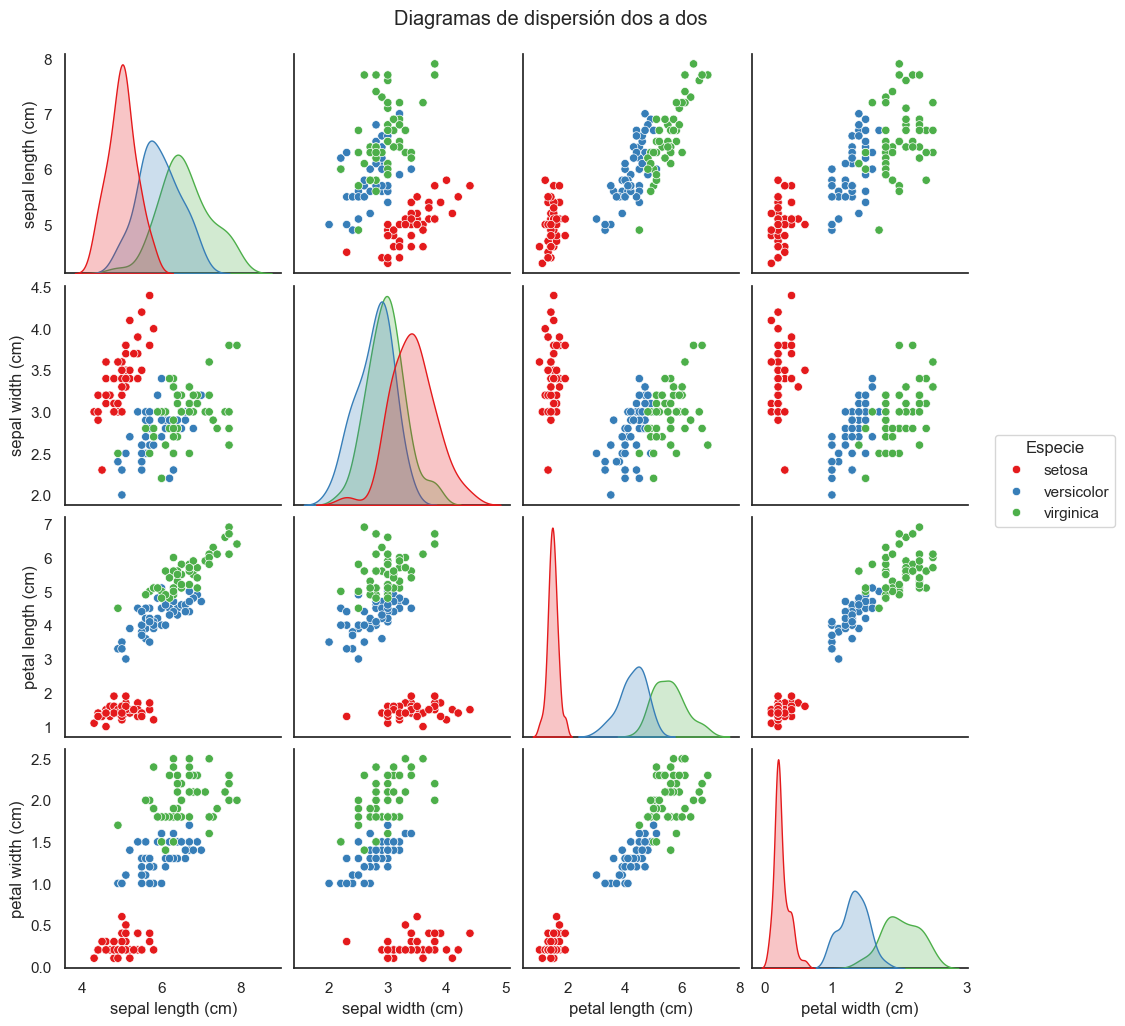

In [7]:
## Visualización bivariada

ax = sns.pairplot(iris.loc[:, iris.columns != "target"], hue="species")
sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.95, 0.5),
    title="Especie",
    frameon=True
)
plt.suptitle("Diagramas de dispersión dos a dos", y=1.025)
plt.tight_layout
plt.show()

> _Fig 3: Pairplot según especies y medidas_

### Análisis preliminar
- La especie $\text{setosa}$ parece estar mejor diferenciada de las otras dos
- En primer lugar `sepal width`, y en segundo `sepal length` no nos separan tan bien a las especies como si lo hacen `petal length` y `petal width`. Los modelos deben tener al menos una de las medidas de los pétalos como dato.
- La relación más lineal es $\text{petal length}(\text{petal width})$

---

### Parte 2 - Modelos Bayesianos

#### A - Modelo bayesiano no jerárquico

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


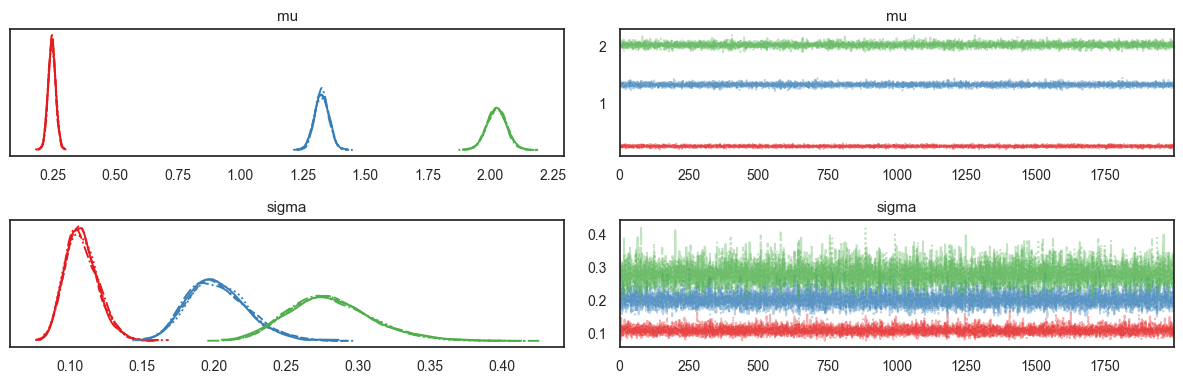

In [8]:
species_idx = iris['target'].values
y = iris['petal width (cm)'].values
n_species = len(iris.species.unique())

with pm.Model() as non_hierarchichal_model:
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_species)
    sigma = pm.HalfNormal('sigma', sigma=5, shape=n_species)

    y_obs = pm.Normal(
        'y_obs',
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=y
    )
    trace_nhm = pm.sample(2000, tune=1000, target_accept=0.9)

az.plot_trace(trace_nhm, figsize=(12, 4))
plt.tight_layout()
plt.show()

> _Fig 4: Ploteo de trazas de `PyMC`_

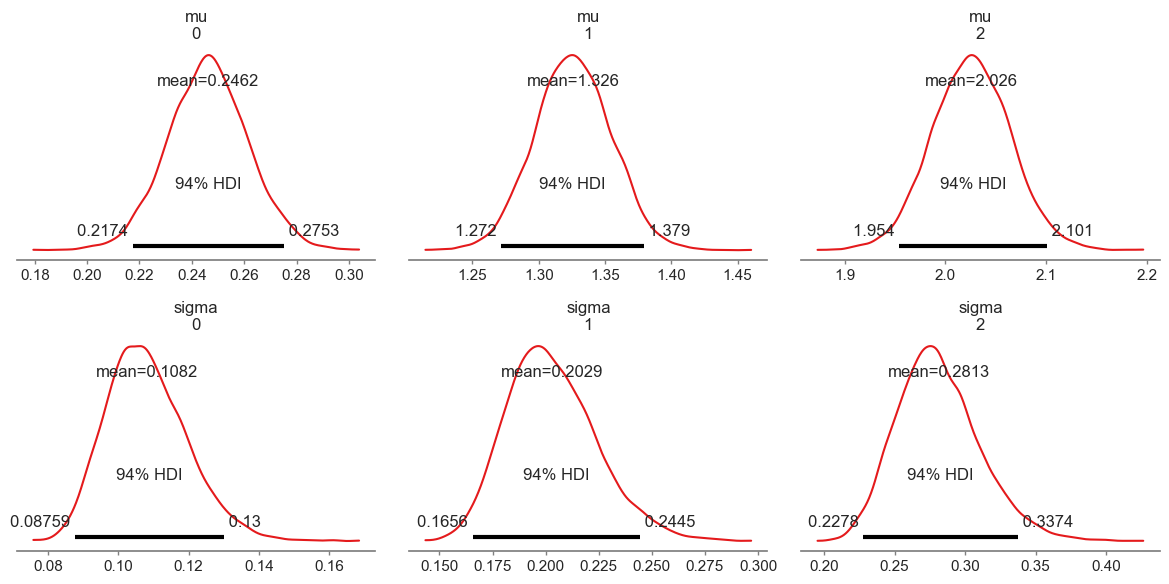

In [21]:
az.plot_posterior(trace_nhm, var_names=['mu', 'sigma'], round_to=4, figsize=(12, 6))
plt.tight_layout()
plt.show()

> _Fig 5: Ploteo de distribuciones posterior para $\mu$ y $\sigma$._

#### Comparación de resultados
- El modelo bayesiano no jerarquico ejecutado por `PyMC` logra capturar eficientemente a los datos. Utilizando priors no informativos, podemos observar descripciones similares (de hecho, bastante idénticas) de las subpoblaciones acorde a cada variable.

#### B - Modelo bayesiano jerárquico

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mu, tau, species_mu, species_sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


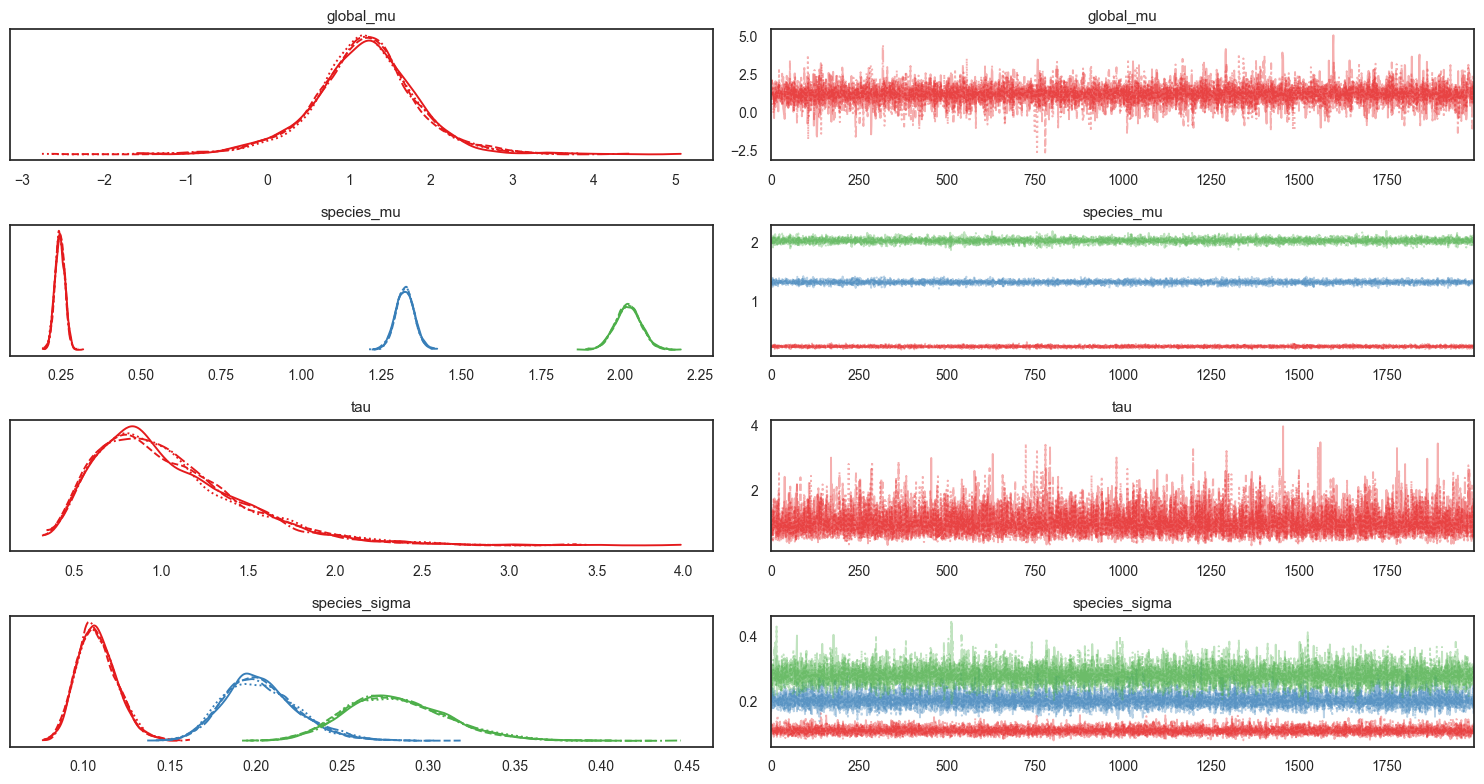

In [14]:
with pm.Model() as hierarchichal_model:
    global_mu = pm.Normal('global_mu', mu=0, sigma=10)
    tau = pm.HalfNormal('tau', sigma=1)

    species_mu = pm.Normal(
        'species_mu',
        mu=global_mu,
        sigma=tau,
        shape=n_species
    )
    species_sigma = pm.HalfNormal(
        'species_sigma',
        sigma=1,
        shape=n_species
    )

    y_obs = pm.Normal(
        'y_obs',
        mu=species_mu[species_idx],
        sigma=species_sigma[species_idx],
        observed=y
    )

    trace_hm = pm.sample(2000, tune=1000, target_accept=0.9)

az.plot_trace(trace_hm, figsize=(15, 8))
plt.tight_layout()
plt.show()

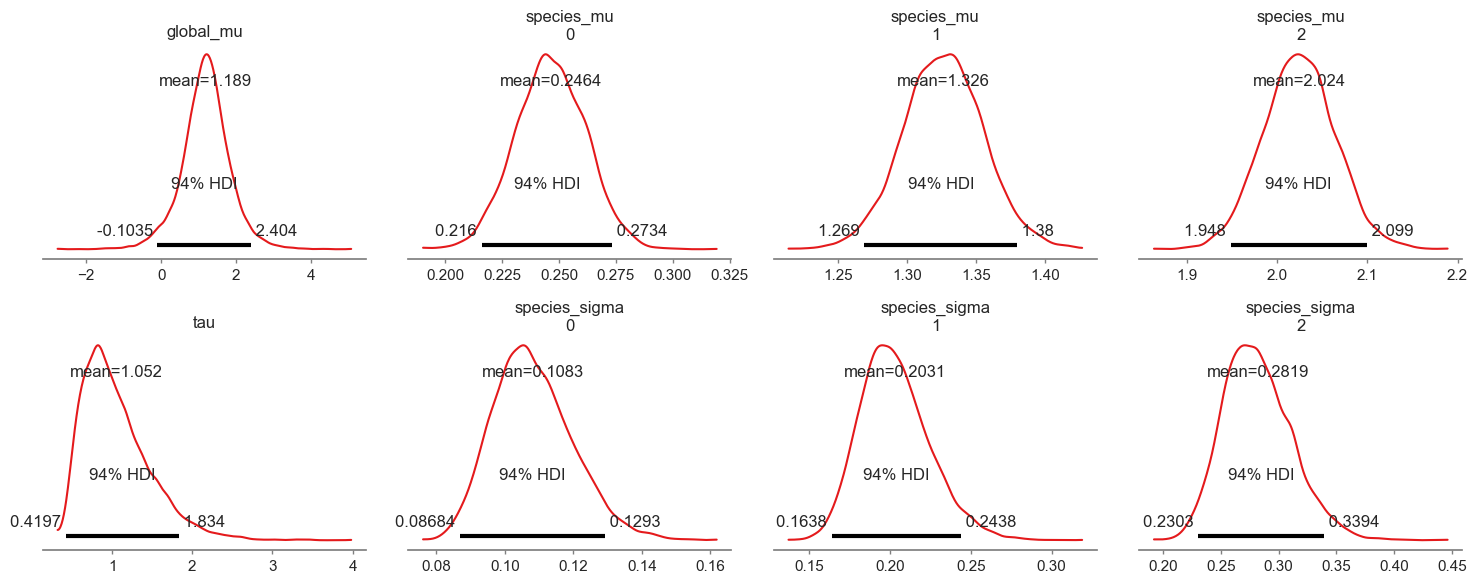

In [22]:
az.plot_posterior(trace_hm, var_names=['global_mu', 'species_mu', 'tau', 'species_sigma'], round_to=4, figsize=(15, 6))
plt.tight_layout()
plt.show()

**¿Hay _shrinkage_?**

En principio, **no**. En la única medida en la que se nota un leve desplazamiento en los bordes del _HDI_, pero no en los valores centrales.